In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

In [3]:
sns.set(font_scale=1.6)

In [4]:
print (tf.__version__)

2.7.0


### Define PINN neural network

In [5]:
######################################################################################
# A basic PINN Tensorflow class for solving a continuous-time in-homogeneous Markov chains
class PINN:
    
    def init_model(number_hidden_layers = 2, num_neurons_per_layer = 50):
        model = tf.keras.Sequential()
        model.add(tf.keras.Input(1))

        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))
        model.add(tf.keras.layers.Dense(num_neurons_per_layer, activation=tf.keras.activations.get('tanh'), 
                                        kernel_initializer='glorot_normal'))

        model.add(tf.keras.layers.Dense(12, activation=tf.keras.activations.get('softmax')))

        return model
    
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r):
        
        ######################################################################################
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)

        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x

        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        self.X_r = X_r

        self.Xu_tf = tf.convert_to_tensor(X_u, dtype=tf.float32)
        self.Yu_tf = tf.convert_to_tensor(Y_u, dtype=tf.float32)
        self.Xr_tf = tf.convert_to_tensor(X_r, dtype=tf.float32)
        
        self.model = self.init_model()
        
        self.iter = 1
        self.loss_log = []
        self.weights_log = []
        self.gradients_log = []
        
    def get_r(self):
        with tf.GradientTape(persistent=True) as g:
            g.watch(self.Xr_tf)
            
            u = self.model(self.Xr_tf)
            
            u1 = u[:,0:1];u2 = u[:,1:2];u3 = u[:,2:3];
            u4 = u[:,3:4];u5 = u[:,4:5];u6 = u[:,5:6];
            u7 = u[:,6:7];u8 = u[:,7:8];u9 = u[:,8:9];
            u10 = u[:,9:10];u11 = u[:,10:11];u12 = u[:,11:12]
            
        #derivatives of state probability
        u_x_1 = g.gradient(u1, self.Xr_tf)/self.sigma_x
        u_x_2 = g.gradient(u2, self.Xr_tf)/self.sigma_x
        u_x_3 = g.gradient(u3, self.Xr_tf)/self.sigma_x
        u_x_4 = g.gradient(u4, self.Xr_tf)/self.sigma_x
        u_x_5 = g.gradient(u5, self.Xr_tf)/self.sigma_x
        u_x_6 = g.gradient(u6, self.Xr_tf)/self.sigma_x
        u_x_7 = g.gradient(u7, self.Xr_tf)/self.sigma_x
        u_x_8 = g.gradient(u8, self.Xr_tf)/self.sigma_x
        u_x_9 = g.gradient(u9, self.Xr_tf)/self.sigma_x
        u_x_10 = g.gradient(u10, self.Xr_tf)/self.sigma_x
        u_x_11 = g.gradient(u11, self.Xr_tf)/self.sigma_x
        u_x_12 = g.gradient(u12, self.Xr_tf)/self.sigma_x
        
        
        #-----------------------------------------------
        # specify transition rate
        #for the element 1
        Lambda2_1_1=7; Mu1_2_1=100;
        #for the element 2
        Lambda2_1_2=10; Mu1_2_2=80;
        #for the element 3
        Lambda3_2_3=10; Lambda3_1_3=0; Lambda2_1_3=7;
        Mu1_3_3=0; Mu1_2_3=120; Mu2_3_3=110
        #-----------------------------------------------
        # calcualte ode terms
        ode_1 = -(Lambda2_1_1+Lambda2_1_2+Lambda3_2_3)*u1+Mu1_2_1*u2+Mu1_2_2*u3+Mu2_3_3*u4;
        ode_2 = Lambda2_1_1*u1-(Mu1_2_1+Lambda2_1_2+Lambda3_2_3)*u2+Mu1_2_2*u5+Mu2_3_3*u6;
        ode_3 = Lambda2_1_2*u1-(Mu1_2_2+Lambda2_1_1+Lambda3_2_3)*u3+Mu1_2_1*u5+Mu2_3_3*u7;
        ode_4 = Lambda3_2_3*u1-(Mu2_3_3+Lambda2_1_1+Lambda2_1_2+Lambda2_1_3)*u4+Mu1_2_1*u6+Mu1_2_2*u7+Mu1_2_3*u8;
        ode_5 = Lambda2_1_2*u2+Lambda2_1_1*u3-(Mu1_2_2+Mu1_2_1+Lambda3_2_3)*u5+Mu2_3_3*u9;
        ode_6 = Lambda3_2_3*u2+Lambda2_1_1*u4-(Mu2_3_3+Mu1_2_1+Lambda2_1_2+Lambda2_1_3)*u6+Mu1_2_2*u9+Mu1_2_3*u10;
        ode_7 = Lambda3_2_3*u3+Lambda2_1_2*u4-(Mu2_3_3+Mu1_2_2+Lambda2_1_1+Lambda2_1_3)*u7+Mu1_2_1*u9+Mu1_2_3*u11;
        ode_8 = Lambda2_1_3*u4-(Mu1_2_3+Lambda2_1_1+Lambda2_1_2)*u8+Mu1_2_1*u10+Mu1_2_2*u11;
        ode_9 = Lambda3_2_3*u5+Lambda2_1_2*u6+Lambda2_1_1*u7-(Mu2_3_3+Mu1_2_2+Mu1_2_1+Lambda2_1_3)*u9+Mu1_2_3*u12;
        ode_10 = Lambda2_1_3*u6+Lambda2_1_1*u8-(Mu1_2_3+Mu1_2_1+Lambda2_1_2)*u10+Mu1_2_2*u12;
        ode_11 = Lambda2_1_3*u7+Lambda2_1_2*u8-(Mu1_2_3+Mu1_2_2+Lambda2_1_1)*u11+Mu1_2_1*u12;
        ode_12 = Lambda2_1_3*u9+Lambda2_1_2*u10+Lambda2_1_1*u11-(Mu1_2_3+Mu1_2_2+Mu1_2_1)*u12
        #-----------------------------------------------
        
        # calculate residuals
        residual_1 = u_x_1-ode_1; residual_2 = u_x_2-ode_2; residual_3 = u_x_3-ode_3
        residual_4 = u_x_4-ode_4; residual_5 = u_x_5-ode_5; residual_6 = u_x_6-ode_6;
        residual_7 = u_x_7-ode_7; residual_8 = u_x_8-ode_8; residual_9 = u_x_9-ode_9;
        residual_10 = u_x_10-ode_10; residual_11 = u_x_11-ode_11; residual_12 = u_x_12-ode_12
        
        #total residual
        residual = tf.reduce_mean(tf.square(residual_1))+tf.reduce_mean(tf.square(residual_2))+\
        tf.reduce_mean(tf.square(residual_3))+tf.reduce_mean(tf.square(residual_4))+\
        tf.reduce_mean(tf.square(residual_5))+tf.reduce_mean(tf.square(residual_6))+\
        tf.reduce_mean(tf.square(residual_7))+tf.reduce_mean(tf.square(residual_8))+\
        tf.reduce_mean(tf.square(residual_9))+tf.reduce_mean(tf.square(residual_10))+\
        tf.reduce_mean(tf.square(residual_11))+tf.reduce_mean(tf.square(residual_12))
        
        loss_1 = tf.reduce_mean(tf.square(residual_1)); loss_2 = tf.reduce_mean(tf.square(residual_2));
        loss_3 = tf.reduce_mean(tf.square(residual_3)); loss_4 = tf.reduce_mean(tf.square(residual_4)); 
        loss_5 = tf.reduce_mean(tf.square(residual_5)); loss_6 = tf.reduce_mean(tf.square(residual_6));
        loss_7 = tf.reduce_mean(tf.square(residual_7)); loss_8 = tf.reduce_mean(tf.square(residual_8));
        loss_9 = tf.reduce_mean(tf.square(residual_9)); loss_10 = tf.reduce_mean(tf.square(residual_10));
        loss_11 = tf.reduce_mean(tf.square(residual_11)); loss_12 = tf.reduce_mean(tf.square(residual_12))
        
        del g
        
        return loss_1, loss_2, loss_3, loss_4, loss_5, loss_6, loss_7, loss_8, loss_9, loss_10, loss_11, loss_12
    

    def loss_fn(self, weight = 1):
        u_pred = self.model(self.Xu_tf)

        loss_u = tf.reduce_mean(tf.square(self.Yu_tf - u_pred))
        loss_1, loss_2, loss_3, loss_4, loss_5, loss_6, loss_7, loss_8, loss_9, loss_10, loss_11, loss_12 = self.get_r()
        
        return [loss_u, loss_1 + loss_2 + loss_3 + loss_4 + loss_5 + loss_6 + loss_7+loss_8+loss_9+loss_10+loss_11+loss_12]
    
    
    def get_grad(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_fn()
        
        g = tape.gradient(loss, self.model.trainable_variables)
        
        loss_u, loss_r = loss[0], loss[1]
        g_u = tape.gradient(loss_u, self.model.trainable_variables)
        g_r = tape.gradient(loss_r, self.model.trainable_variables)
        
        del tape
        
        return loss, g, g_u, g_r
    
    def get_grad_by_PCG(self):
        with tf.GradientTape() as tape:
            loss = self.loss_fn()
            
            assert type(loss) is list
            loss = tf.stack(loss)
            tf.random.shuffle(loss)

            grads_task = tf.vectorized_map(lambda x: tf.concat([tf.reshape(grad, [-1,]) 
                                for grad in tape.gradient(x, self.model.trainable_variables)
                                if grad is not None], axis=0), loss)
        
        num_tasks = len(loss)

        # Compute gradient projections.
        def proj_grad(grad_task):
            for k in range(num_tasks):
                inner_product = tf.reduce_sum(grad_task*grads_task[k])
                proj_direction = inner_product / tf.reduce_sum(grads_task[k]*grads_task[k])
                grad_task = grad_task - tf.minimum(proj_direction, 0.) * grads_task[k]
            return grad_task

        proj_grads_flatten = tf.vectorized_map(proj_grad, grads_task)

        # Unpack flattened projected gradients back to their original shapes.
        proj_grads = []
        for j in range(num_tasks):
            start_idx = 0
            for idx, var in enumerate(self.model.trainable_variables):
                grad_shape = var.get_shape()
                flatten_dim = np.prod([grad_shape.dims[i].value for i in range(len(grad_shape.dims))])
                proj_grad = proj_grads_flatten[j][start_idx:start_idx+flatten_dim]
                proj_grad = tf.reshape(proj_grad, grad_shape)
                if len(proj_grads) < len(self.model.trainable_variables):
                    proj_grads.append(proj_grad)
                else:
                    proj_grads[idx] += proj_grad               
                start_idx += flatten_dim

        grads_and_vars = list(zip(proj_grads, self.model.trainable_variables))
        
        del tape
        return loss, proj_grads, None, None
    
    def callback(self):
        if self.iter % 1000 == 0:
            print('Iteration {:05d}: loss = {}'.format(self.iter, ','.join(map(str, self.current_loss))))
        self.iter += 1
    
    def train(self, N, optimizer, method):
        """This method performs a gradient descent type optimization."""
        
        @tf.function
        def train_step():
            if method == 'original':
                loss, grad_theta, g_u, g_r = self.get_grad()
                
            if method == 'PCG_gradient':
                loss, grad_theta, g_u, g_r = self.get_grad_by_PCG()
            
            # Perform gradient descent step
            optimizer.apply_gradients(zip(grad_theta, self.model.trainable_variables))
            
            return loss, grad_theta, g_u, g_r
        
        for i in range(N):
            
            loss, grad_theta, g_u, g_r = train_step()
            
            self.current_loss = tf.convert_to_tensor(loss).numpy()
            self.loss_log.append(self.current_loss)
            self.callback()
                
    def predict(self, x_star):
        mu, sigma = self.mu_x, self.sigma_x
        x_star_normalized = (x_star-mu)/sigma
        
        return self.model(x_star_normalized)

### Generate training data

In [6]:
######################################################################################
# Number of training data
N_u = 1                       # Boundary condition data on u(x)  
N_r = 500                     # Number of collocation points for minimizing the PDE residual
lb  = np.array([0.0])         # Left boundary of the domain
ub  = np.array([0.2])         # Right boundary of the domain

# Generate training data
x_u = np.array([[0]])  ##TZ
y_u = np.array([[1,0,0,0,0,0,0,0,0,0,0,0]])   # Solution at boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)

In [7]:
N = 40000

### Train PINN without PCGrad

In [8]:
PINN_solver = PINN(x_u, y_u, x_r)
initial_weights = PINN_solver.model.get_weights()

In [9]:
optim = tf.keras.optimizers.Adam(epsilon=1e-30)
PINN_solver.train(N=N, optimizer=optim, method = 'original')

Iteration 01000: loss = 0.006947746,0.1822183
Iteration 02000: loss = 0.0066290875,0.04415668
Iteration 03000: loss = 0.0065332316,0.018832356
Iteration 04000: loss = 0.006477092,0.009171603
Iteration 05000: loss = 0.006417597,0.01156584
Iteration 06000: loss = 0.0064059407,0.0026066175
Iteration 07000: loss = 0.0063831653,0.0015768283
Iteration 08000: loss = 0.006364143,0.0009309512
Iteration 09000: loss = 0.0063476064,0.0029521277
Iteration 10000: loss = 0.006337361,0.00039380306
Iteration 11000: loss = 0.006326551,0.00028699508
Iteration 12000: loss = 0.006321224,0.00020044048
Iteration 13000: loss = 0.0063159517,0.00017478204
Iteration 14000: loss = 0.006301414,0.00048327615
Iteration 15000: loss = 0.0063041844,8.585864e-05
Iteration 16000: loss = 0.0063005127,6.655517e-05
Iteration 17000: loss = 0.00629787,6.3766805e-05
Iteration 18000: loss = 0.006294273,3.9600778e-05
Iteration 19000: loss = 0.0062919543,3.054181e-05
Iteration 20000: loss = 0.0062894225,2.3787114e-05
Iteration 21

### Train PINN with PCGrad

In [10]:
PINN_solver_pcgrad = PINN(x_u, y_u, x_r)
PINN_solver_pcgrad.model.set_weights(initial_weights)

In [11]:
%%time

optim = tf.keras.optimizers.Adam(epsilon=1e-30)
PINN_solver_pcgrad.train(N=N, optimizer=optim, method = 'PCG_gradient')

Iteration 01000: loss = 0.0069204406,0.18590698
Iteration 02000: loss = 0.0065874862,0.040144343
Iteration 03000: loss = 0.006500255,0.015953412
Iteration 04000: loss = 0.0064465594,0.0067062024
Iteration 05000: loss = 0.00634364,0.0050159213
Iteration 06000: loss = 0.005990259,0.022423616
Iteration 07000: loss = 0.005631287,0.06999573
Iteration 08000: loss = 0.00084208493,9.394641
Iteration 09000: loss = 0.0005945251,0.4576383
Iteration 10000: loss = 0.0003536388,0.20957081
Iteration 11000: loss = 0.00022313184,0.13470617
Iteration 12000: loss = 7.694278e-05,0.4377712
Iteration 13000: loss = 7.407522e-05,0.19354424
Iteration 14000: loss = 8.057917e-05,0.06289734
Iteration 15000: loss = 6.574734e-05,0.03819249
Iteration 16000: loss = 1.5666037e-05,0.34228632
Iteration 17000: loss = 1.6526441e-05,0.1756379
Iteration 18000: loss = 3.3294247e-05,0.01783517
Iteration 19000: loss = 2.9659146e-05,0.012251338
Iteration 20000: loss = 1.4859801e-05,0.03138422
Iteration 21000: loss = 1.14625755e

### Visualize loss function

In [12]:
pinn_loss_log = np.vstack(PINN_solver.loss_log)
pinn_pcgrad_loss_log = np.vstack(PINN_solver_pcgrad.loss_log)

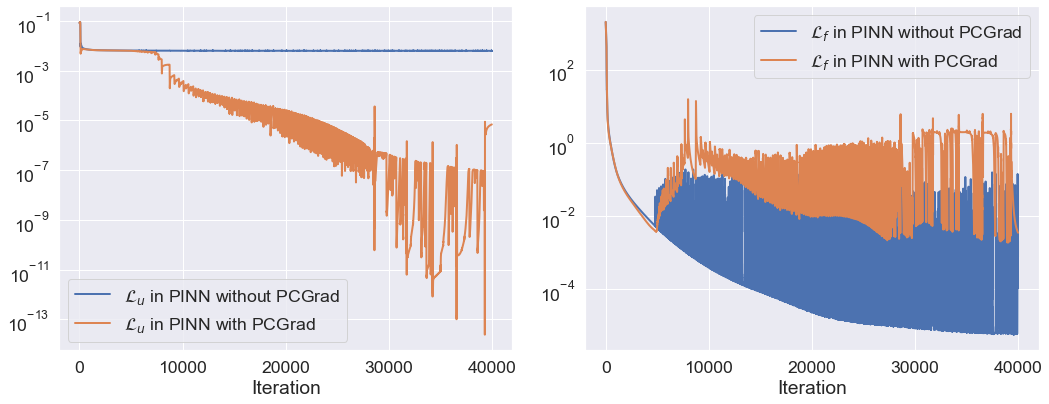

In [13]:
f, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(x = range(len(pinn_loss_log[:, 0])), y = pinn_loss_log[:, 0],  linewidth = 2, 
             label = "$\mathcal{L}_u$ in PINN without PCGrad", ax = axes[0])
sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 0])), y = pinn_pcgrad_loss_log[:, 0],  linewidth = 2, 
             label = "$\mathcal{L}_u$ in PINN with PCGrad", ax = axes[0])

axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xlabel("Iteration")

sns.lineplot(x = range(len(pinn_loss_log[:, 1])), y = pinn_loss_log[:, 1],  linewidth = 2, 
             label = "$\mathcal{L}_f$ in PINN without PCGrad", ax = axes[1])

sns.lineplot(x = range(len(pinn_pcgrad_loss_log[:, 1])), y = pinn_pcgrad_loss_log[:, 1],  linewidth = 2, 
             label = "$\mathcal{L}_f$ in PINN with PCGrad", ax = axes[1])

axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.savefig("performance_comparison_medium_homo.pdf")

### Solution quality comparison

#### Load solver solution

In [14]:
def get_system_performance(df):
    
    df['system_3.5'] = df['state_1']
    df['system_2.0'] = df['state_2']
    df['system_1.8'] = df['state_4'] + df['state_6']
    df['system_1.5'] = df['state_3'] + df['state_7']
    df['system_0'] = df['state_5'] + df['state_8'] + df['state_9'] + df['state_10'] + df['state_11'] + df['state_12']
    
    return df

In [15]:
state_column_names = ['state_1', 'state_2', 'state_3', 'state_4', 'state_5', 'state_6', 'state_7',
                      'state_8', 'state_9', 'state_10', 'state_11', 'state_12']

In [16]:
matlab_solver_solution_df = pd.read_csv('homo_example2.4.csv')
matlab_solver_solution_df.columns = ['time'] + state_column_names

In [17]:
matlab_solver_solution_df.drop(labels='time', inplace=True, axis = 1)

In [18]:
matlab_solver_solution_df = get_system_performance(matlab_solver_solution_df)

In [19]:
matlab_solver_solution_df.head()

,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,state_12,system_3.5,system_2.0,system_1.8,system_1.5,system_0
0,0.98947,0.002718,0.003901,0.003872,0.000011,0.000011,0.000016,0.000005,4.414700e-08,1.555500e-08,2.232800e-08,6.382400e-11,0.98947,0.002718,0.003883,0.003917,0.000016
1,0.97953,0.005252,0.007579,0.007458,0.000045,0.000044,0.000064,0.000023,4.313800e-07,1.523900e-07,2.192600e-07,7.835700e-10,0.97953,0.005252,0.007502,0.007643,0.000068
2,0.96988,0.007703,0.011154,0.010913,0.000089,0.000087,0.000126,0.000045,1.060200e-06,3.744100e-07,5.387400e-07,1.808400e-09,0.96988,0.007703,0.011000,0.011280,0.000136
3,0.96087,0.009961,0.014494,0.014072,0.000154,0.000150,0.000218,0.000078,2.442700e-06,8.729400e-07,1.266300e-06,1.058000e-08,0.96087,0.009961,0.014222,0.014712,0.000237
4,0.95218,0.012125,0.017716,0.017086,0.000229,0.000221,0.000323,0.000117,4.300800e-06,1.551000e-06,2.263800e-06,2.732400e-08,0.95218,0.012125,0.017307,0.018039,0.000354


#### Load MCS solution

In [20]:
MCS_solution_df = pd.read_csv('MCS_homo_example2.4.csv')
MCS_solution_df.columns = ['time'] + state_column_names

In [21]:
MCS_solution_df.drop(labels='time', inplace=True, axis = 1)

In [22]:
MCS_solution_df = get_system_performance(MCS_solution_df)

In [23]:
MCS_solution_df.tail()

,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,state_12,system_3.5,system_2.0,system_1.8,system_1.5,system_0
495,0.758657,0.052800,0.093607,0.068742,0.006795,0.005020,0.008733,0.004197,0.000647,0.000280,0.000490,0.000030,0.758657,0.052800,0.073762,0.102340,0.012440
496,0.758652,0.052792,0.093613,0.068965,0.006777,0.004978,0.008590,0.004170,0.000670,0.000278,0.000472,0.000043,0.758652,0.052792,0.073942,0.102203,0.012410
497,0.758830,0.052727,0.093530,0.068947,0.006760,0.004967,0.008587,0.004205,0.000660,0.000273,0.000470,0.000043,0.758830,0.052727,0.073915,0.102117,0.012410
498,0.758760,0.052933,0.093713,0.068810,0.006685,0.005000,0.008507,0.004177,0.000647,0.000255,0.000478,0.000035,0.758760,0.052933,0.073810,0.102220,0.012278
499,0.758548,0.053018,0.093963,0.068763,0.006707,0.004947,0.008430,0.004172,0.000678,0.000273,0.000478,0.000025,0.758548,0.053018,0.073710,0.102392,0.012333


#### Load PINN solver

In [24]:
mu, sigma = PINN_solver.mu_x, PINN_solver.sigma_x

######################################################################################
# Test data for validating the model predictions
n_star = 500+1
x_star = np.linspace(lb, ub, n_star)[1:] #N_star = x_star.shape[0] 

In [25]:
y_pred = PINN_solver.predict(x_star)
y_pred_pcgrad = PINN_solver_pcgrad.predict(x_star)

In [26]:
y_pred_df = pd.DataFrame(y_pred.numpy(), columns = state_column_names)
y_pred_pcgrad_df = pd.DataFrame(y_pred_pcgrad.numpy(), columns = state_column_names)

In [27]:
y_pred_df = get_system_performance(y_pred_df)
y_pred_pcgrad_df = get_system_performance(y_pred_pcgrad_df)

In [30]:
y_diff_matlab = pd.DataFrame.abs(matlab_solver_solution_df - y_pred_df)
y_diff_pcgrad_matlab = pd.DataFrame.abs(matlab_solver_solution_df - y_pred_pcgrad_df)

#### Generate histogram of prediction difference with respect to each state

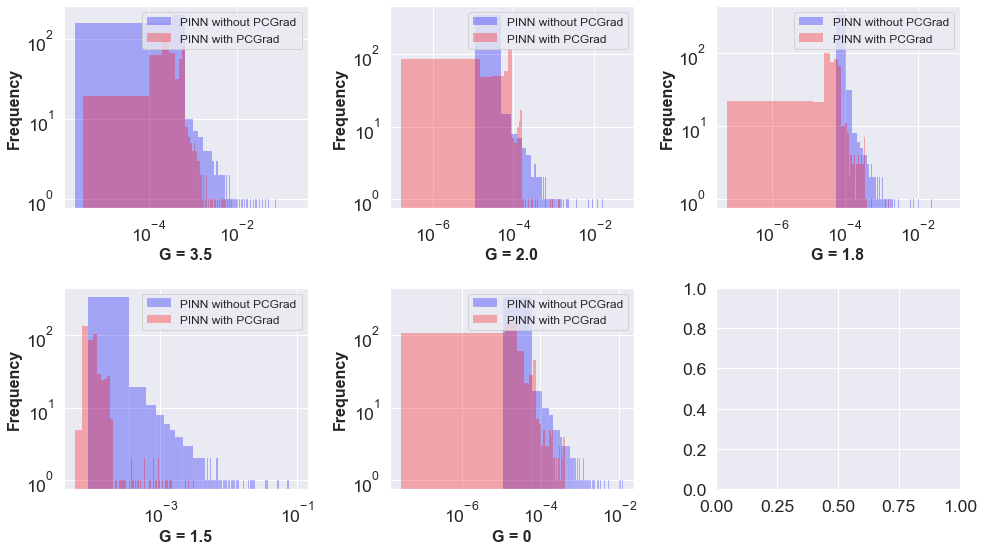

In [31]:
f, axes = plt.subplots(2, 3, figsize=(14, 8))

sns.histplot(np.abs(y_diff_matlab['system_3.5']), ax=axes[0][0], alpha =0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['system_3.5']), ax=axes[0][0], alpha =0.3, color='red', label='PINN with PCGrad')

axes[0][0].legend(fontsize=12)
axes[0][0].set_xscale('log')
axes[0][0].set_yscale('log')
axes[0][0].set_xlabel('G = 3.5', fontdict=dict(weight='bold'), fontsize=16)
axes[0][0].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff_matlab['system_2.0']), ax=axes[0][1], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['system_2.0']), alpha=0.3, ax=axes[0][1], color='red', label='PINN with PCGrad')
axes[0][1].legend(fontsize=12)
axes[0][1].set_xscale('log')
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('G = 2.0', fontdict=dict(weight='bold'), fontsize=16)
axes[0][1].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)

sns.histplot(np.abs(y_diff_matlab['system_1.8']), ax=axes[0][2], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['system_1.8']), alpha=0.3, ax=axes[0][2], color='red', label='PINN with PCGrad')
axes[0][2].legend(fontsize=12)
axes[0][2].set_xscale('log')
axes[0][2].set_yscale('log')
axes[0][2].set_xlabel('G = 1.8', fontdict=dict(weight='bold'), fontsize=16)
axes[0][2].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff_matlab['system_1.5']), ax=axes[1][0], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['system_1.5']), alpha=0.3, ax=axes[1][0], color='red', label='PINN with PCGrad')
axes[1][0].legend(fontsize=12)
axes[1][0].set_xscale('log')
axes[1][0].set_yscale('log')
axes[1][0].set_xlabel('G = 1.5', fontdict=dict(weight='bold'), fontsize=16)
axes[1][0].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)


sns.histplot(np.abs(y_diff_matlab['system_0']), ax=axes[1][1], alpha=0.3, color='blue', label='PINN without PCGrad')
sns.histplot(np.abs(y_diff_pcgrad_matlab['system_0']), alpha=0.3, ax=axes[1][1], color='red', label='PINN with PCGrad')
axes[1][1].legend(fontsize=12)
axes[1][1].set_xscale('log')
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('G = 0', fontdict=dict(weight='bold'), fontsize=16)
axes[1][1].set_ylabel('Frequency', fontdict=dict(weight='bold'), fontsize=16)

plt.tight_layout(pad=1)
plt.savefig("histogram_medium_homo.pdf")

#### Compare PINN predictions with Matlab solver

In [32]:
sns.set_style("white")
plt.rcParams['legend.fontsize'] = 12

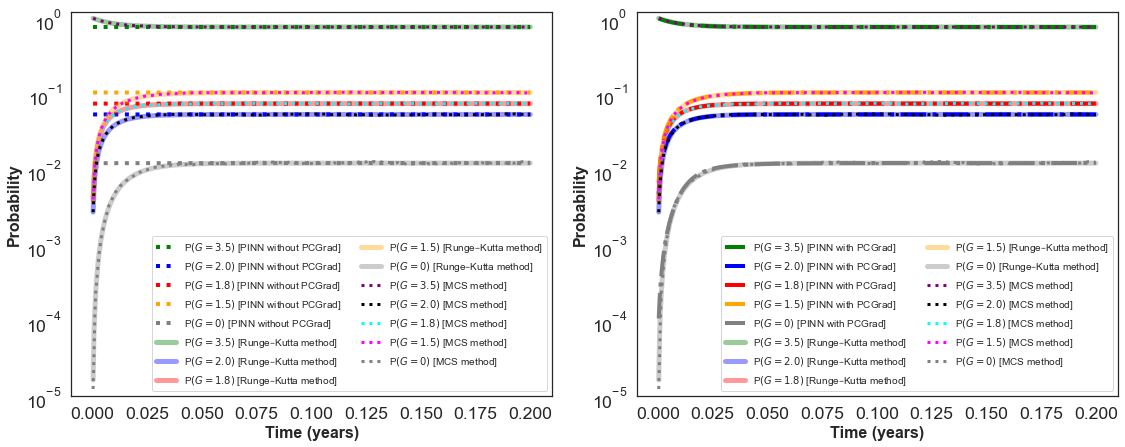

In [47]:
f, ax = plt.subplots(1, 2, figsize=(16, 6.6))

sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN without PCGrad]', 
             linewidth = 4, color = 'green', linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'blue', linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'red', linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'orange', linestyle='dotted', ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = y_pred_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN without PCGrad]',
             linewidth = 4, color = 'gray', linestyle='dotted', ax=ax[0])


sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5, ax=ax[0])


sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [MCS method]', linestyle='dotted',
             color = 'purple', alpha=1, dashes=True, linewidth = 3, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [MCS method]', linestyle='dotted',
             color = 'black', alpha=1, dashes=True, linewidth = 3, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [MCS method]', linestyle='dotted',
             color = 'cyan', alpha=1, dashes=True, linewidth = 3, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [MCS method]', linestyle='dotted',
             color = 'fuchsia', alpha=1, dashes=True, linewidth = 3, ax=ax[0])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [MCS method]', linestyle='dotted',
             color = 'gray', alpha=1, dashes=True, linewidth = 3, ax=ax[0])

ax[0].legend(ncol=2, fontsize=10)
ax[0].set_yscale("log")
ax[0].set_ylim([1e-5, 1.2])
ax[0].set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax[0].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)


sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_3.5'], label = r'P$\left(G=3.5 \right)$ [PINN with PCGrad]',
             color = 'green', linestyle='dashdot', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_2.0'], label = r'P$\left(G=2.0 \right)$ [PINN with PCGrad]', 
             color = 'blue', linestyle='dashdot', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_1.8'], label = r'P$\left(G=1.8 \right)$ [PINN with PCGrad]', 
             color = 'red', linestyle='dashdot', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_1.5'], label = r'P$\left(G=1.5 \right)$ [PINN with PCGrad]',
             color = 'orange', linestyle='dashdot', linewidth = 4, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = y_pred_pcgrad_df['system_0'], label = r'P$\left(G=0 \right)$ [PINN with PCGrad]',
             color = 'gray', linestyle='dashdot', linewidth = 4, ax=ax[1])

sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [Runge–Kutta method]',
             color = 'green', alpha=0.4, dashes=True, linewidth = 5, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [Runge–Kutta method]',
             color = 'blue', alpha=0.4, dashes=True, linewidth = 5, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [Runge–Kutta method]',
             color = 'red', alpha=0.4, dashes=True, linewidth = 5, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [Runge–Kutta method]',
             color = 'orange', alpha=0.4, dashes=True, linewidth = 5, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = matlab_solver_solution_df['system_0'], 
             label = r'P$\left(G=0 \right)$ [Runge–Kutta method]',
             color = 'gray', alpha=0.4, dashes=True, linewidth = 5, ax=ax[1])

sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['system_3.5'], 
             label = r'P$\left(G=3.5 \right)$ [MCS method]', linestyle='dotted',
             color = 'purple', alpha=1, dashes=True, linewidth = 3, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['system_2.0'], 
             label = r'P$\left(G=2.0 \right)$ [MCS method]', linestyle='dotted',
             color = 'black', alpha=1, dashes=True, linewidth = 3, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['system_1.8'], 
             label = r'P$\left(G=1.8 \right)$ [MCS method]', linestyle='dotted',
             color = 'cyan', alpha=1, dashes=True, linewidth = 3, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['system_1.5'], 
             label = r'P$\left(G=1.5 \right)$ [MCS method]', linestyle='dotted',
             color = 'fuchsia', alpha=1, dashes=True, linewidth = 3, ax=ax[1])
sns.lineplot(x = x_star.flatten(), y = MCS_solution_df['system_0'],
             label = r'P$\left(G=0 \right)$ [MCS method]', linestyle='dotted',
             color = 'gray', alpha=1, dashes=True, linewidth = 3, ax=ax[1])

ax[1].legend(ncol=2, fontsize=10)
ax[1].set_yscale("log")
ax[1].set_ylim([1e-5, 1.2])
ax[1].set_xlabel("Time (years)", fontdict=dict(weight='bold'), fontsize=16)
ax[1].set_ylabel("Probability", fontdict=dict(weight='bold'), fontsize=16)


plt.tight_layout()
plt.savefig("comparison_medium_homo.pdf")

#### Derive RMSE

In [36]:
y_diff_matlab = matlab_solver_solution_df - y_pred_df
y_diff_pcgrad_matlab = matlab_solver_solution_df - y_pred_pcgrad_df

y_diff_MCS = MCS_solution_df - y_pred_df
y_diff_pcgrad_MCS = MCS_solution_df - y_pred_pcgrad_df

In [37]:
y_diff_matlab['mse'] = y_diff_matlab.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)

y_diff_matlab['rmse'] = y_diff_matlab['mse'].apply(np.sqrt)

y_diff_pcgrad_matlab['mse'] = y_diff_pcgrad_matlab.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + 
                                                         x['system_1.8']**2 + x['system_1.5']**2 + x['system_0']**2, axis = 1)

y_diff_pcgrad_matlab['rmse'] = y_diff_pcgrad_matlab['mse'].apply(np.sqrt)

In [38]:
y_diff_MCS['mse'] = y_diff_MCS.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + x['system_1.8']**2 + 
                             x['system_1.5']**2 + x['system_0']**2, axis = 1)

y_diff_MCS['rmse'] = y_diff_MCS['mse'].apply(np.sqrt)

y_diff_pcgrad_MCS['mse'] = y_diff_pcgrad_MCS.apply(lambda x: x['system_3.5']**2 + x['system_2.0']**2 + 
                                                x['system_1.8']**2 + x['system_1.5']**2 + x['system_0']**2, axis = 1)

y_diff_pcgrad_MCS['rmse'] = y_diff_pcgrad_MCS['mse'].apply(np.sqrt)

In [39]:
print ('RMSE between PINN without PCGrad and matlab solver is', np.mean(y_diff_matlab['rmse']))
print ('RMSE between PINN with PCGrad and matlab solver is', np.mean(y_diff_pcgrad_matlab['rmse']))

print ('RMSE of between PINN without PCGrad and MCS method is', np.mean(y_diff_MCS['rmse']))
print ('RMSE of between PINN with PCGrad and MCS method is', np.mean(y_diff_pcgrad_MCS['rmse']))

RMSE between PINN without PCGrad and matlab solver is 0.013412615318331444
RMSE between PINN with PCGrad and matlab solver is 0.0007692930779419896
RMSE of between PINN without PCGrad and MCS method is 0.013766829801342553
RMSE of between PINN with PCGrad and MCS method is 0.0012116506117540817


In [40]:
(np.mean(y_diff_matlab['rmse']) - np.mean(y_diff_pcgrad_matlab['rmse']))/np.mean(y_diff_matlab['rmse'])

0.9426440660763175

In [41]:
(np.mean(y_diff_MCS['rmse']) - np.mean(y_diff_pcgrad_MCS['rmse']))/np.mean(y_diff_MCS['rmse'])

0.9119876813152785